# 3er Parcial, 26-nov-2025
### Elaboró: Anette Paulina González Solano
__Dataset a utilizar__: https://physionet.org/content/eegmmidb/1.0.0/S001/#files-panel

__Descripción del dataset:__ Registros de EEG de 64 canales, 109 sujetos, 14 ensayos por sujeto.

Basales (1 minuto): 
- R01 – Reposo, ojos abiertos
- R02 – Reposo, ojos cerrados

Tareas (2 minutos c/u): Cada tarea se repite x3.
- Tarea 1 (real): mover mano izquierda o derecha.
- Tarea 2 (imaginada): imaginar mover mano izquierda o derecha.
- Tarea 3 (real): mover ambas manos (sup) o mover los pies (inf).
- Tarea 4 (imaginada): imaginar mover ambas manos (sup) o los pies (inf).

Eventos:
- T0: reposo.
- T1: movimiento/imaginar movimiento de: mano izquierda (en Tareas 1 y 2) o ambas manos (en Tareas 3 y 4).
- T2: movimiento/imaginar movimiento de: mano derecha (en Tareas 1 y 2) o pies (en Tareas 3 y 4).

In [13]:
# Importar librerías
import numpy as np
import pandas as pd
import networkx as nx
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

# Ensayos 3 y 4

In [33]:
# Rutas de archivos
ruta_ensayo3 = r"C:\Users\apgso\OneDrive\Documentos\modelos-2026-1\Neurociencias-2026-1\S04_parciales\parcial-3\eeg-motor-movementimagery_Ensayo_03.xlsx"
ruta_ensayo4 = r"C:\Users\apgso\OneDrive\Documentos\modelos-2026-1\Neurociencias-2026-1\S04_parciales\parcial-3\eeg-motor-movementimagery_Ensayo_04.xlsx"
ruta_coord   = r"C:\Users\apgso\OneDrive\Documentos\modelos-2026-1\Neurociencias-2026-1\S04_parciales\parcial-3\MI_coordinates.csv"

# Cargar datos
ensayo3_dict = pd.read_excel(ruta_ensayo3, sheet_name=None, index_col=0)
ensayo4_dict = pd.read_excel(ruta_ensayo4, sheet_name=None, index_col=0)
ensayo3_dfs = [df for df in ensayo3_dict.values()]
ensayo4_dfs = [df for df in ensayo4_dict.values()]
coords = pd.read_csv(ruta_coord)
coords.set_index("canal", drop=True, inplace=True)

# Limpiar NaN, inf y simetría
def limpiar_matriz(df):
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(0)
    return df

ensayo3_dfs = [limpiar_matriz(df) for df in ensayo3_dfs]
ensayo4_dfs = [limpiar_matriz(df) for df in ensayo4_dfs]


ESTADÍSTICOS COMPLETOS – ENSAYO 3

              P25       P50       P75     Media       Var  Mu+Sigma
Min      0.018413  0.061750  0.196867  0.149821  0.028163  0.340611
Max      0.514472  0.674805  0.819681  0.626848  0.071038  0.857561
Mediana  0.144574  0.273808  0.484181  0.327700  0.051902  0.563312
MAD      0.069559  0.080172  0.074567  0.063494  0.007724  0.062669

ESTADÍSTICOS COMPLETOS – ENSAYO 4

              P25       P50       P75     Media       Var  Mu+Sigma
Min      0.016915  0.055561  0.210152  0.148728  0.021637  0.343459
Max      0.680820  0.768026  0.859416  0.758803  0.073265  0.905900
Mediana  0.135265  0.288254  0.480688  0.333706  0.052075  0.570516
MAD      0.066142  0.090804  0.077428  0.068714  0.007063  0.062107

Umbral Óptimo Ensayo 3 = 0.48418134013104924
Umbral Óptimo Ensayo 4 = 0.4806880928873297


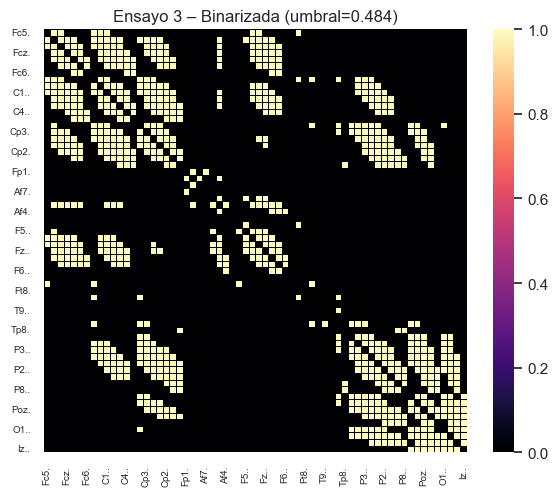

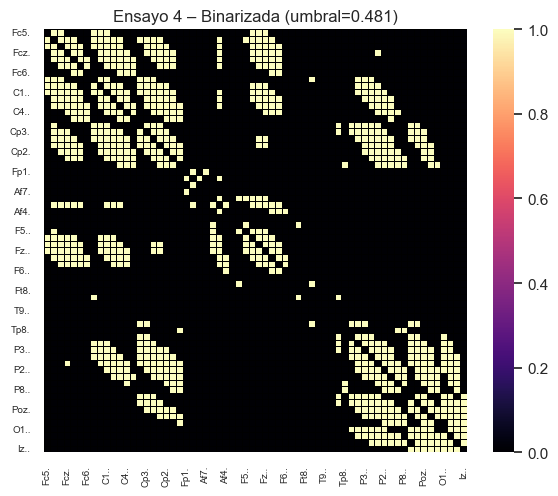

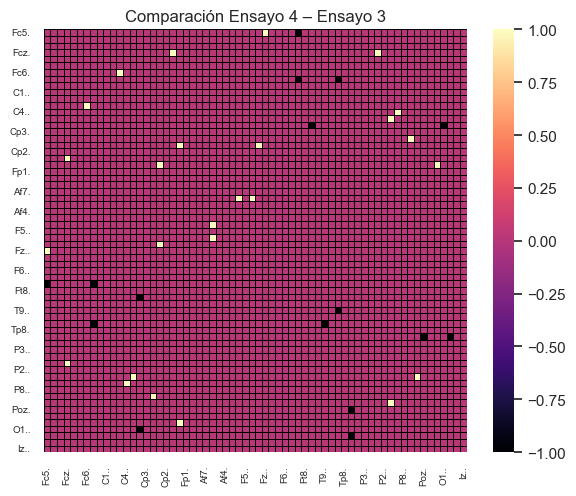

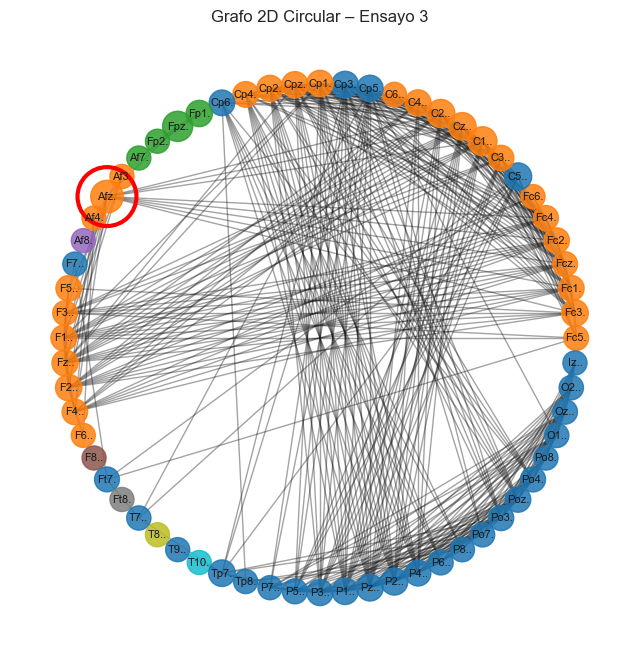

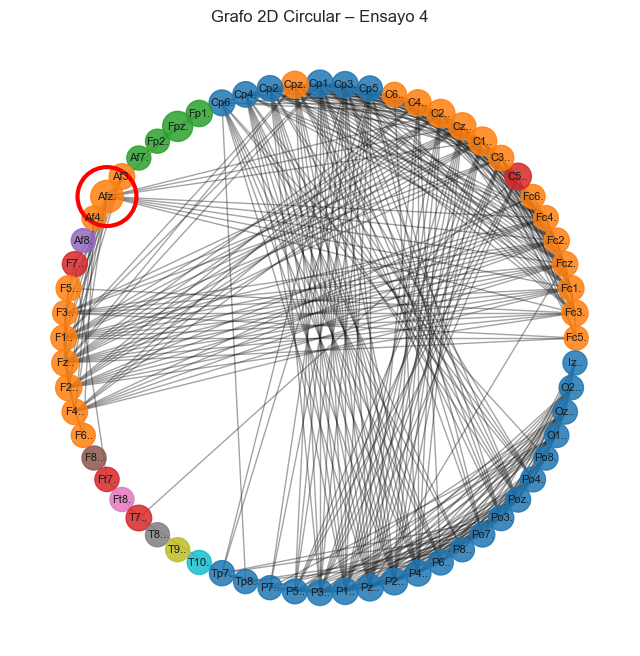

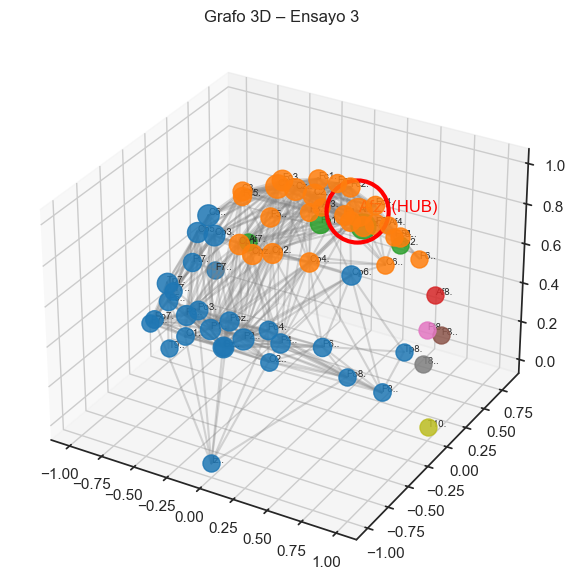

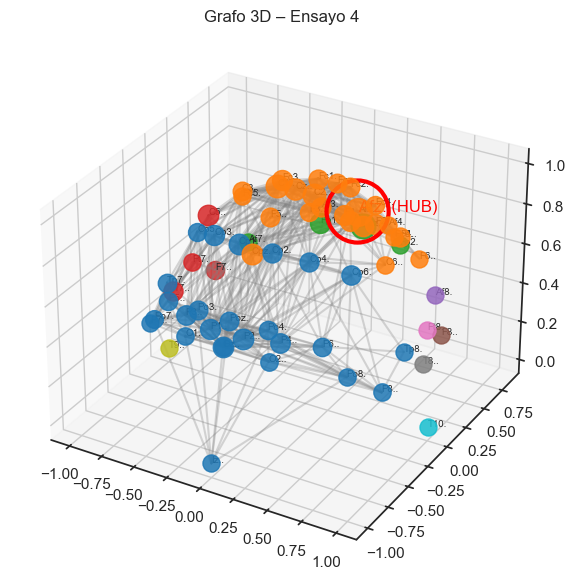

In [49]:
# ESTADÍSTICOS PARA DEFINIR UMBRAL
def tabla_estadisticos_completa(lista_dfs, nombre):
    th25, th50, th75, medias, varianzas, mu_sigma = [], [], [], [], [], []

    for df in lista_dfs:
        data = df.values.flatten()

        th25.append(np.percentile(data, 25))
        th50.append(np.percentile(data, 50))
        th75.append(np.percentile(data, 75))
        medias.append(np.mean(data))
        varianzas.append(np.var(data))
        mu_sigma.append(np.mean(data) + np.std(data))

    tabla = pd.DataFrame({
        "P25":       th25,
        "P50":       th50,
        "P75":       th75,
        "Media":     medias,
        "Var":       varianzas,
        "Mu+Sigma":  mu_sigma
    })

    resumen = pd.DataFrame(index=["Min", "Max", "Mediana", "MAD"])
    for col in tabla.columns:
        resumen[col] = [
            np.min(tabla[col]),
            np.max(tabla[col]),
            np.median(tabla[col]),
            stats.median_abs_deviation(tabla[col])
        ]

    print(f"\n==============================")
    print(f"ESTADÍSTICOS COMPLETOS – {nombre}")
    print(f"==============================\n")
    print(resumen)

    return resumen

tabla3 = tabla_estadisticos_completa(ensayo3_dfs, "ENSAYO 3")
tabla4 = tabla_estadisticos_completa(ensayo4_dfs, "ENSAYO 4")


# SELECCIÓN DEL UMBRAL ÓPTIMO
def elegir_umbral_optimo(tabla):
    p50 = float(tabla.loc["Mediana", "P50"])
    p75 = float(tabla.loc["Mediana", "P75"])
    ms = float(tabla.loc["Mediana", "Mu+Sigma"])
    if abs(p50 - p75) < 0.07:
        return p50
    if p75 < 0.60:
        return p75
    return ms

umbral3 = elegir_umbral_optimo(tabla3)
umbral4 = elegir_umbral_optimo(tabla4)

print("\nUmbral Óptimo Ensayo 3 =", umbral3)
print("Umbral Óptimo Ensayo 4 =", umbral4)


# BINARIZACIÓN / FILTRADO
def filtrar(lista_dfs, threshold, porcentaje=0.6):
    stack = np.stack([df.values for df in lista_dfs])
    above = stack > threshold
    required = int(np.ceil(porcentaje * len(lista_dfs)))
    binaria = above.sum(axis=0) >= required

    return pd.DataFrame(binaria, index=lista_dfs[0].index, columns=lista_dfs[0].columns)

res3 = filtrar(ensayo3_dfs, umbral3, 0.6)
res4 = filtrar(ensayo4_dfs, umbral4, 0.6)


# HEATMAPS (con colorbar activado)
def heatmap_bonito(mat, titulo):
    plt.figure(figsize=(6,5))
    sns.heatmap(mat,
                cmap="magma",
                linewidths=0.4,
                linecolor="black",
                cbar=True,    # <-- colorbar activado
                square=True)
    plt.title(titulo, fontsize=12)
    plt.xticks(rotation=90, fontsize=7)
    plt.yticks(rotation=0, fontsize=7)
    plt.tight_layout()
    plt.show()

heatmap_bonito(res3, f"Ensayo 3 – Binarizada (umbral={umbral3:.3f})")
heatmap_bonito(res4, f"Ensayo 4 – Binarizada (umbral={umbral4:.3f})")
heatmap_bonito(res4.astype(int) - res3.astype(int), "Comparación Ensayo 4 – Ensayo 3")


# GRAFOS
G3 = nx.from_pandas_adjacency(res3)
G4 = nx.from_pandas_adjacency(res4)

bet3 = nx.betweenness_centrality(G3)
bet4 = nx.betweenness_centrality(G4)

hub3 = max(bet3, key=bet3.get)
hub4 = max(bet4, key=bet4.get)


# COMUNIDADES
com3 = nx.algorithms.community.greedy_modularity_communities(G3)
com4 = nx.algorithms.community.greedy_modularity_communities(G4)


# GRAFO 2D CIRCULAR — COLORES ORIGINALES (tab10)
def grafo2D_circular(G, comunidades, centralidad, hub, titulo):
    mapa_color = {}
    for i, com in enumerate(comunidades):
        for nodo in com:
            mapa_color[nodo] = i

    sizes = [300 + 2000*centralidad[n] for n in G.nodes()]
    colores = [mapa_color[n] for n in G.nodes()]
    pos = nx.circular_layout(G)

    plt.figure(figsize=(8,8))
    nx.draw_networkx_nodes(
        G, pos,
        node_size=sizes,
        node_color=colores,
        cmap="tab10",
        alpha=0.85
    )
    nx.draw_networkx_edges(G, pos, alpha=0.4)
    nx.draw_networkx_labels(G, pos, font_size=8)

    nx.draw_networkx_nodes(
        G, pos,
        nodelist=[hub],
        node_size=1800,
        node_color="none",
        edgecolors="red",
        linewidths=3
    )

    plt.title(titulo)
    plt.axis("off")
    plt.show()

grafo2D_circular(G3, com3, bet3, hub3, "Grafo 2D Circular – Ensayo 3")
grafo2D_circular(G4, com4, bet4, hub4, "Grafo 2D Circular – Ensayo 4")


# GRAFO 3D
def grafo3D(G, comunidades, centralidad, hub, coords, titulo):
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection="3d")

    mapa_color = {}
    for i, com in enumerate(comunidades):
        for nodo in com:
            mapa_color[nodo] = i

    for nodo in G.nodes():
        x, y, z = coords.loc[nodo, ["x","y","z"]]
        ax.scatter(
            x, y, z,
            s=150 + 2000*centralidad[nodo],
            c=plt.cm.tab10(mapa_color[nodo] / len(comunidades)),
            alpha=0.85
        )
        ax.text(x, y, z, nodo, fontsize=7)

    hx, hy, hz = coords.loc[hub, ["x","y","z"]]
    ax.scatter(
        hx, hy, hz,
        s=2000,
        facecolors="none",
        edgecolors="red",
        linewidths=3
    )
    ax.text(hx, hy, hz, f"{hub} (HUB)", color="red")

    for u, v in G.edges():
        x = [coords.loc[u,"x"], coords.loc[v,"x"]]
        y = [coords.loc[u,"y"], coords.loc[v,"y"]]
        z = [coords.loc[u,"z"], coords.loc[v,"z"]]
        ax.plot(x, y, z, c="gray", alpha=0.3)

    ax.set_title(titulo)
    plt.tight_layout()
    plt.show()

grafo3D(G3, com3, bet3, hub3, coords, "Grafo 3D – Ensayo 3")
grafo3D(G4, com4, bet4, hub4, coords, "Grafo 3D – Ensayo 4")

# Ensayos 5 y 6

In [42]:
# Rutas de archivos
ruta_ensayo5 = r"C:\Users\apgso\OneDrive\Documentos\modelos-2026-1\Neurociencias-2026-1\S04_parciales\parcial-3\eeg-motor-movementimagery_Ensayo_05.xlsx"
ruta_ensayo6 = r"C:\Users\apgso\OneDrive\Documentos\modelos-2026-1\Neurociencias-2026-1\S04_parciales\parcial-3\eeg-motor-movementimagery_Ensayo_06.xlsx"
ruta_coord   = r"C:\Users\apgso\OneDrive\Documentos\modelos-2026-1\Neurociencias-2026-1\S04_parciales\parcial-3\MI_coordinates.csv"

# Cargar datos
ensayo5_dict = pd.read_excel(ruta_ensayo5, sheet_name=None, index_col=0)
ensayo6_dict = pd.read_excel(ruta_ensayo6, sheet_name=None, index_col=0)
ensayo5_dfs = [df for df in ensayo5_dict.values()]
ensayo6_dfs = [df for df in ensayo6_dict.values()]
coords = pd.read_csv(ruta_coord)
coords.set_index("canal", drop=True, inplace=True)

# Limpiar NaN, inf y simetría
def limpiar_matriz(df):
    df = df.replace([np.inf, -np.inf], np.nan)
    df = df.fillna(0)
    return df

ensayo5_dfs = [limpiar_matriz(df) for df in ensayo5_dfs]
ensayo6_dfs = [limpiar_matriz(df) for df in ensayo6_dfs]


ESTADÍSTICOS COMPLETOS – ENSAYO 5

              P25       P50       P75     Media       Var  Mu+Sigma
Min      0.017846  0.057751  0.205711  0.149197  0.028275  0.343770
Max      0.522739  0.651729  0.805549  0.634132  0.074710  0.845545
Mediana  0.152787  0.293580  0.500263  0.345151  0.051587  0.579643
MAD      0.070700  0.086319  0.075435  0.066217  0.006488  0.067294

ESTADÍSTICOS COMPLETOS – ENSAYO 6

              P25       P50       P75     Media       Var  Mu+Sigma
Min      0.018750  0.043536  0.202194  0.153129  0.027363  0.361116
Max      0.542689  0.667679  0.808475  0.649729  0.073475  0.849871
Mediana  0.144532  0.276807  0.493891  0.333420  0.052823  0.572410
MAD      0.061041  0.074638  0.070225  0.058393  0.006397  0.058840

Umbral Óptimo Ensayo 5 = 0.5002626141665745
Umbral Óptimo Ensayo 6 = 0.4938908110453685


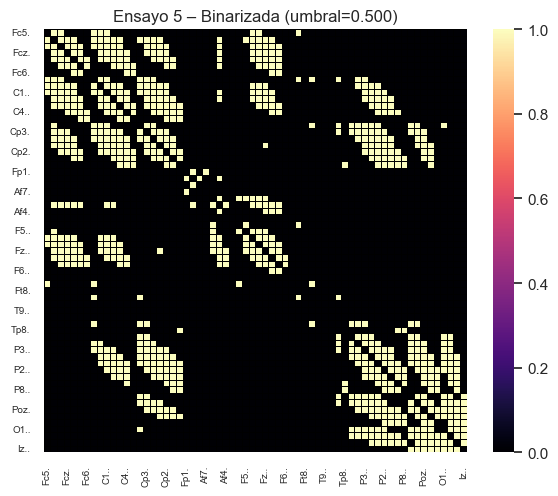

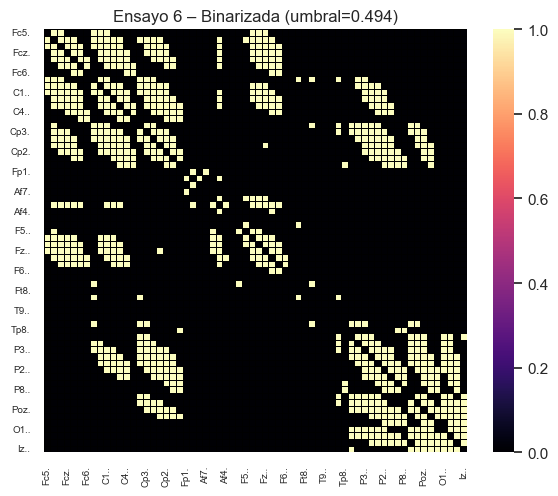

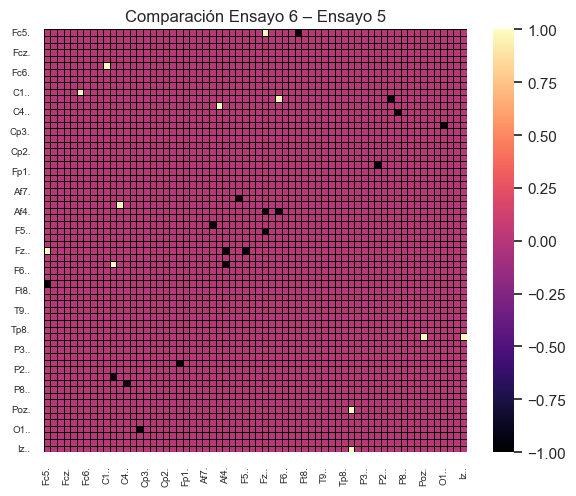


Hub Ensayo 5: Afz.
Hub Ensayo 6: Afz.


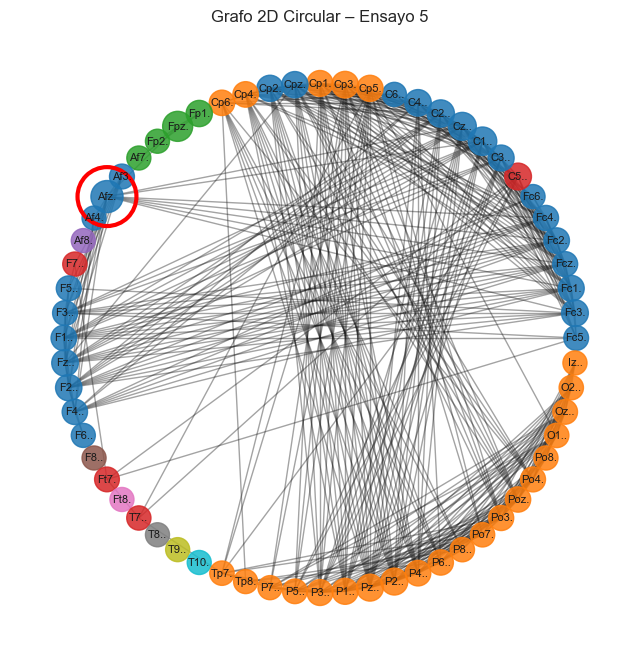

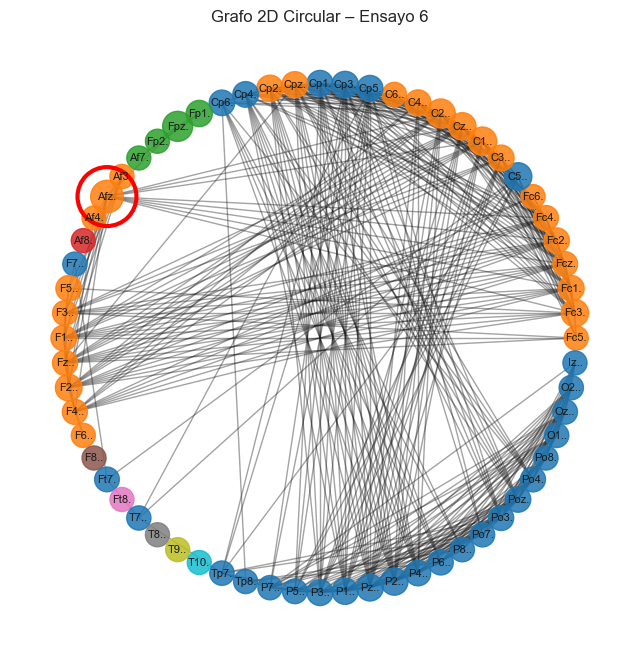

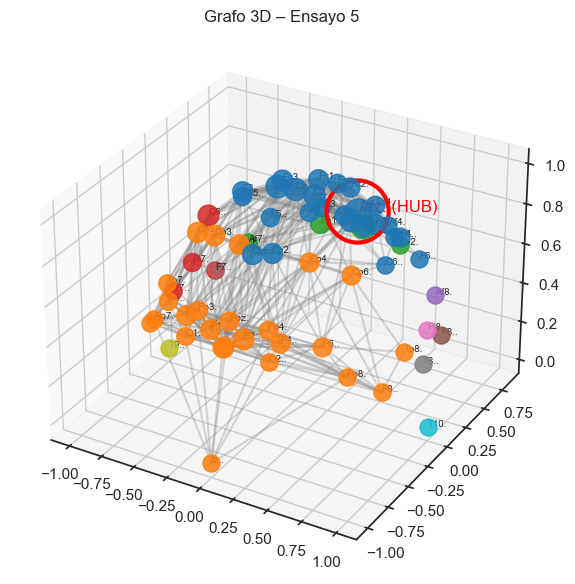

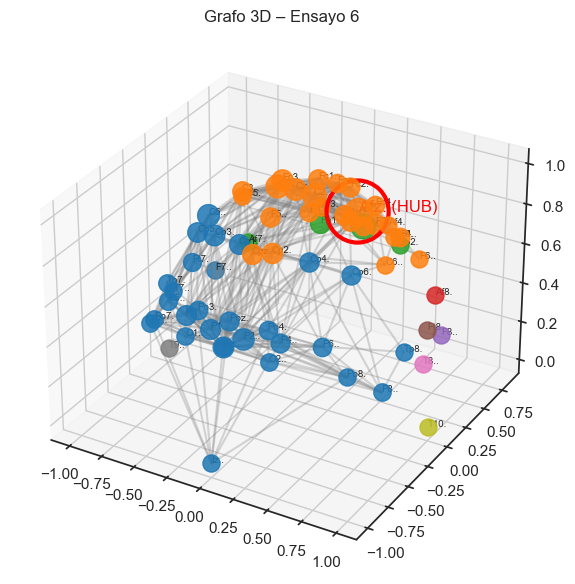

In [48]:
# ESTADÍSTICOS PARA DEFINIR UMBRAL
def tabla_estadisticos_completa(lista_dfs, nombre):
    th25, th50, th75, medias, varianzas, mu_sigma = [], [], [], [], [], []

    for df in lista_dfs:
        data = df.values.flatten()

        th25.append(np.percentile(data, 25))
        th50.append(np.percentile(data, 50))
        th75.append(np.percentile(data, 75))
        medias.append(np.mean(data))
        varianzas.append(np.var(data))
        mu_sigma.append(np.mean(data) + np.std(data))

    tabla = pd.DataFrame({
        "P25":       th25,
        "P50":       th50,
        "P75":       th75,
        "Media":     medias,
        "Var":       varianzas,
        "Mu+Sigma":  mu_sigma
    })

    resumen = pd.DataFrame(index=["Min", "Max", "Mediana", "MAD"])
    for col in tabla.columns:
        resumen[col] = [
            np.min(tabla[col]),
            np.max(tabla[col]),
            np.median(tabla[col]),
            stats.median_abs_deviation(tabla[col])
        ]

    print(f"\n==============================")
    print(f"ESTADÍSTICOS COMPLETOS – {nombre}")
    print(f"==============================\n")
    print(resumen)

    return resumen


tabla5 = tabla_estadisticos_completa(ensayo5_dfs, "ENSAYO 5")
tabla6 = tabla_estadisticos_completa(ensayo6_dfs, "ENSAYO 6")


# SELECCIÓN DE UMBRAL ÓPTIMO
def elegir_umbral_optimo(tabla):
    p50 = float(tabla.loc["Mediana", "P50"])
    p75 = float(tabla.loc["Mediana", "P75"])
    ms  = float(tabla.loc["Mediana", "Mu+Sigma"])

    if abs(p50 - p75) < 0.07:
        return p50
    if p75 < 0.60:
        return p75
    return ms

umbral5 = elegir_umbral_optimo(tabla5)
umbral6 = elegir_umbral_optimo(tabla6)

print("\nUmbral Óptimo Ensayo 5 =", umbral5)
print("Umbral Óptimo Ensayo 6 =", umbral6)


# BINARIZACIÓN / FILTRADO
def filtrar(lista_dfs, threshold, porcentaje=0.6):
    stack = np.stack([df.values for df in lista_dfs])
    above = stack > threshold
    required = int(np.ceil(porcentaje * len(lista_dfs)))
    binaria = above.sum(axis=0) >= required

    return pd.DataFrame(binaria,
                        index=lista_dfs[0].index,
                        columns=lista_dfs[0].columns)

res5 = filtrar(ensayo5_dfs, umbral5, 0.6)
res6 = filtrar(ensayo6_dfs, umbral6, 0.6)


# HEATMAPS CON COLORBAR ACTIVADO
def heatmap_bonito(mat, titulo):
    plt.figure(figsize=(6,5))
    sns.heatmap(mat,
                cmap="magma",
                linewidths=0.4,
                linecolor="black",
                cbar=True,       # <── ACTIVADO
                square=True)
    plt.title(titulo, fontsize=12)
    plt.xticks(rotation=90, fontsize=7)
    plt.yticks(rotation=0, fontsize=7)
    plt.tight_layout()
    plt.show()

heatmap_bonito(res5, f"Ensayo 5 – Binarizada (umbral={umbral5:.3f})")
heatmap_bonito(res6, f"Ensayo 6 – Binarizada (umbral={umbral6:.3f})")

heatmap_bonito(res6.astype(int) - res5.astype(int),
               "Comparación Ensayo 6 – Ensayo 5")


# GRAFOS
G5 = nx.from_pandas_adjacency(res5)
G6 = nx.from_pandas_adjacency(res6)

bet5 = nx.betweenness_centrality(G5)
bet6 = nx.betweenness_centrality(G6)

hub5 = max(bet5, key=bet5.get)
hub6 = max(bet6, key=bet6.get)

print("\nHub Ensayo 5:", hub5)
print("Hub Ensayo 6:", hub6)


# COMUNIDADES
com5 = nx.algorithms.community.greedy_modularity_communities(G5)
com6 = nx.algorithms.community.greedy_modularity_communities(G6)


# GRAFO 2D CIRCULAR
def grafo2D_circular(G, comunidades, centralidad, hub, titulo):
    mapa_color = {}
    for i, com in enumerate(comunidades):
        for nodo in com:
            mapa_color[nodo] = i

    sizes   = [300 + 2000*centralidad[n] for n in G.nodes()]
    colores = [mapa_color[n] for n in G.nodes()]
    pos     = nx.circular_layout(G)

    plt.figure(figsize=(8,8))
    nx.draw_networkx_nodes(
        G, pos,
        node_size=sizes,
        node_color=colores,
        cmap="tab10",
        alpha=0.85
    )
    nx.draw_networkx_edges(G, pos, alpha=0.4)
    nx.draw_networkx_labels(G, pos, font_size=8)

    nx.draw_networkx_nodes(
        G, pos,
        nodelist=[hub],
        node_size=1800,
        node_color="none",
        edgecolors="red",
        linewidths=3
    )

    plt.title(titulo)
    plt.axis("off")
    plt.show()

grafo2D_circular(G5, com5, bet5, hub5, "Grafo 2D Circular – Ensayo 5")
grafo2D_circular(G6, com6, bet6, hub6, "Grafo 2D Circular – Ensayo 6")


# GRAFO 3D
def grafo3D(G, comunidades, centralidad, hub, coords, titulo):
    fig = plt.figure(figsize=(7,6))
    ax = fig.add_subplot(111, projection="3d")

    mapa_color = {}
    for i, com in enumerate(comunidades):
        for nodo in com:
            mapa_color[nodo] = i

    for nodo in G.nodes():
        x, y, z = coords.loc[nodo, ["x","y","z"]]
        ax.scatter(
            x, y, z,
            s=150 + 2000*centralidad[nodo],
            c=plt.cm.tab10(mapa_color[nodo] / len(comunidades)),
            alpha=0.85
        )
        ax.text(x, y, z, nodo, fontsize=7)

    hx, hy, hz = coords.loc[hub, ["x","y","z"]]
    ax.scatter(
        hx, hy, hz,
        s=2000,
        facecolors="none",
        edgecolors="red",
        linewidths=3
    )
    ax.text(hx, hy, hz, f"{hub} (HUB)", color="red")

    for u, v in G.edges():
        x = [coords.loc[u,"x"], coords.loc[v,"x"]]
        y = [coords.loc[u,"y"], coords.loc[v,"y"]]
        z = [coords.loc[u,"z"], coords.loc[v,"z"]]
        ax.plot(x, y, z, c="gray", alpha=0.3)

    ax.set_title(titulo)
    plt.tight_layout()
    plt.show()

grafo3D(G5, com5, bet5, hub5, coords, "Grafo 3D – Ensayo 5")
grafo3D(G6, com6, bet6, hub6, coords, "Grafo 3D – Ensayo 6")


## Conclusiones
- Métricas (P50, P75, media, varianza, Mu+Sigma) se mantuvieron en rangos casi idénticos en los cuatro ensayos → conectividad estable entre tareas reales e imaginadas.
- Umbrales óptimos fueron prácticamente iguales (0.48–0.50) → misma distribución de conexiones en tareas.
- Ensayos 5 y 6 (Tarea 3: bilateral) mostraron valores ligeramente mayores → mayor demanda e integración interhemisférica.
- El hub recurrente en AFz indica un nodo frontal estable e integrador en todas las tareas.